[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Trusted-AI/AIF360/blob/main/examples/sklearn/demo_reject_option_classification.ipynb)

# Reject Option based Classification

Reject Option based Classification (ROC) is a simple but powerful post-processing method which works by simply assigning favorable outcomes to members of the unprivileged group and unfavorable outcomes to members of the privileged groups when the prediction probability from an estimator is within a "critical region" of ambiguity. We parameterize this critical region with a threshold (center) and margin (radius). We can then run a naive search over all combinations of these parameters to find the best tradeoff between predictive performance and fairness.

In [1]:
#Install AIF360
!pip install 'aif360' 

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import tri
from mpl_toolkits import mplot3d
import pandas as pd

from sklearn.linear_model import LogisticRegression

from aif360.sklearn.postprocessing import RejectOptionClassifierCV, PostProcessingMeta
from aif360.sklearn.datasets import fetch_adult
from aif360.algorithms.postprocessing.reject_option_classification import _get_pareto_frontier

Fetch Adult dataset:

In [3]:
X, y, sample_weight = fetch_adult()

Encode protected attributes, labels, and categorical features:

In [4]:
X.index = pd.MultiIndex.from_arrays(X.index.codes, names=X.index.names)
y.index = pd.MultiIndex.from_arrays(y.index.codes, names=y.index.names)
y = pd.Series(y.factorize(sort=True)[0], index=y.index)
X = pd.get_dummies(X)

We can combine our ROC grid search with a logistic regression classifier using the meta-estimator class to complete the whole process in one step. Note: `RejectOptionClassifierCV` does not actually perform true cross-validation since this algorithm does not "learn" anything but this class will perform the grid search and, optionally, "refit" the post-processor using the optimal threshold and margin (best balanced accuracy given fairness score >= 0.8 for disparate impact or >= -0.1 for all other scorers). The `n_jobs` argument specifies the number of parallel processes to use (-1 means use all CPUs). By using the meta-estimator, we ensure the data used to fit the post-processor is a held-out validation set.

In [5]:
metric = 'disparate_impact'
pp = PostProcessingMeta(LogisticRegression(solver='liblinear'),
        RejectOptionClassifierCV('sex', scoring=metric, step=0.02, n_jobs=-1))
pp.fit(X, y)
pp.postprocessor_.best_params_

{'margin': 0.12000000000000001, 'prot_attr': 'sex', 'threshold': 0.18}

We can plot the results of the grid search in 2D and look at the Pareto front (cyan) for the tradeoff between balanced accuracy and disparate impact. The starred point represents the best params chosen by the refitting protocol.

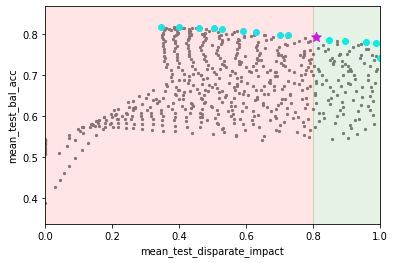

In [6]:
res = pd.DataFrame(pp.postprocessor_.cv_results_)
ax = res.plot.scatter('mean_test_'+metric, 'mean_test_bal_acc', c='gray', marker='.')

all_pts = res[['mean_test_'+metric, 'mean_test_bal_acc']].to_numpy()
pareto_idx = _get_pareto_frontier(all_pts)
ax.scatter(all_pts[pareto_idx, 0], all_pts[pareto_idx, 1], c='cyan')

refit_idx = pp.postprocessor_.best_index_
ax.scatter(all_pts[refit_idx, 0], all_pts[refit_idx, 1], s=100, c='magenta', marker='*')

ba = res.mean_test_bal_acc
ax.fill_betweenx([ba.min()-0.05, ba.max()+0.05], 1, 0.8, color='g', alpha=0.1)
ax.fill_betweenx([ba.min()-0.05, ba.max()+0.05], 0.8, color='r', alpha=0.1)
ax.margins(0)

We can also visualize the 4D surface of our choices of threshold and margin and their corresponding balanced accuracy and disparate impact by plotting in 3D and using color to represent the fourth dimension. Again, the Pareto front points and "best" choice are shown in cyan and magenta, respectively (although they may be covered up by the surface plot from some angles). We can see that increasing the margin improves fairness but past a certain point it begins to overcompensate. We can also see that, in this case, lower thresholds generally lead to better balanced accuracy.

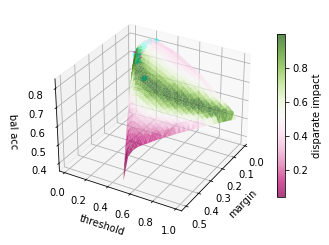

In [7]:
f = plt.figure()
ax = f.add_subplot(projection='3d')
surf = ax.plot_trisurf(res.param_margin, res.param_threshold, res.mean_test_bal_acc, cmap='PiYG', alpha=0.75)
triangles = tri.Triangulation(res.param_margin, res.param_threshold).triangles
colors = res.mean_test_disparate_impact.to_numpy().take(triangles).max(axis=1)
surf.set_array(colors)
f.colorbar(surf, shrink=0.75, label='disparate impact');

pareto_pts = res.iloc[pareto_idx]
ax.scatter(pareto_pts.param_margin, pareto_pts.param_threshold, pareto_pts.mean_test_bal_acc, c='cyan')

best_pt = res.loc[pp.postprocessor_.best_index_]
ax.scatter(best_pt.param_margin, best_pt.param_threshold, best_pt.mean_test_bal_acc,
           c='magenta', marker='*', s=100)

ax.set_xlabel('margin')
ax.set_ylabel('threshold')
ax.set_zlabel('bal acc')
ax.view_init(30, 30)